In [1]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from IPython.display import Audio, display


In [2]:
def calcular_perfil_ruido(audio_noise, fft_size=2048, hop_size=512):
    n_frames = (len(audio_noise) - fft_size) // hop_size

    sum_mag = np.zeros(fft_size // 2 + 1)

    janela = np.hanning(fft_size)
    count = 0

    for i in range(n_frames):
        start = i * hop_size

        frame = audio_noise[start : start + fft_size] * janela

        mag = np.abs(np.fft.rfft(frame))

        sum_mag += mag
        count += 1

    return sum_mag / count

In [3]:
def reducao_ruido_espectral(audio_signal, noise_profile, fft_size=2048, hop_size=512, agresividade=1.5):
    
    n_samples = len(audio_signal)
    output_signal = np.zeros(n_samples)

    janela = np.hanning(fft_size)

    num_frames = (n_samples - fft_size) // hop_size

    for i in range(num_frames):
        start = i * hop_size
        end = start + fft_size

        frame = audio_signal[start:end] * janela

        fft_frame = np.fft.rfft(frame)

        fft_mag = np.abs(fft_frame)
        fft_phase = np.angle(fft_frame)


        new_mag = fft_mag - (noise_profile * agresividade)

        new_mag = np.maximum(new_mag, 0)

        new_fft = new_mag * np.exp(1j * fft_phase)

        processed_frame = np.fft.irfft(new_fft)

        output_signal[start:end] += processed_frame
    
    return output_signal

In [4]:
sr_ruido, raw_ruido = wav.read('amostra.wav')
sr_audio, raw_audio = wav.read('audio_com_furadeira.wav')


data_ruido = raw_ruido.astype(float) / 32768.0
data_audio = raw_audio.astype(float) / 32768.0

if len(data_ruido.shape) > 1: data_ruido = data_ruido[:, 0]
if len(data_audio.shape) > 1: data_audio = data_audio[:, 0]

FFT_SIZE = 2048
HOP_SIZE = 512


perfil_ruido = calcular_perfil_ruido(data_ruido, FFT_SIZE, HOP_SIZE)

audio_limpo = reducao_ruido_espectral(data_audio, perfil_ruido, FFT_SIZE, HOP_SIZE, agresividade=2.0)


max_val = np.max(np.abs(audio_limpo))
if max_val > 0:
    audio_limpo = audio_limpo / max_val * 0.9

wav.write('audio_da_paz.wav', sr_audio, (audio_limpo * 32767).astype(np.int16))

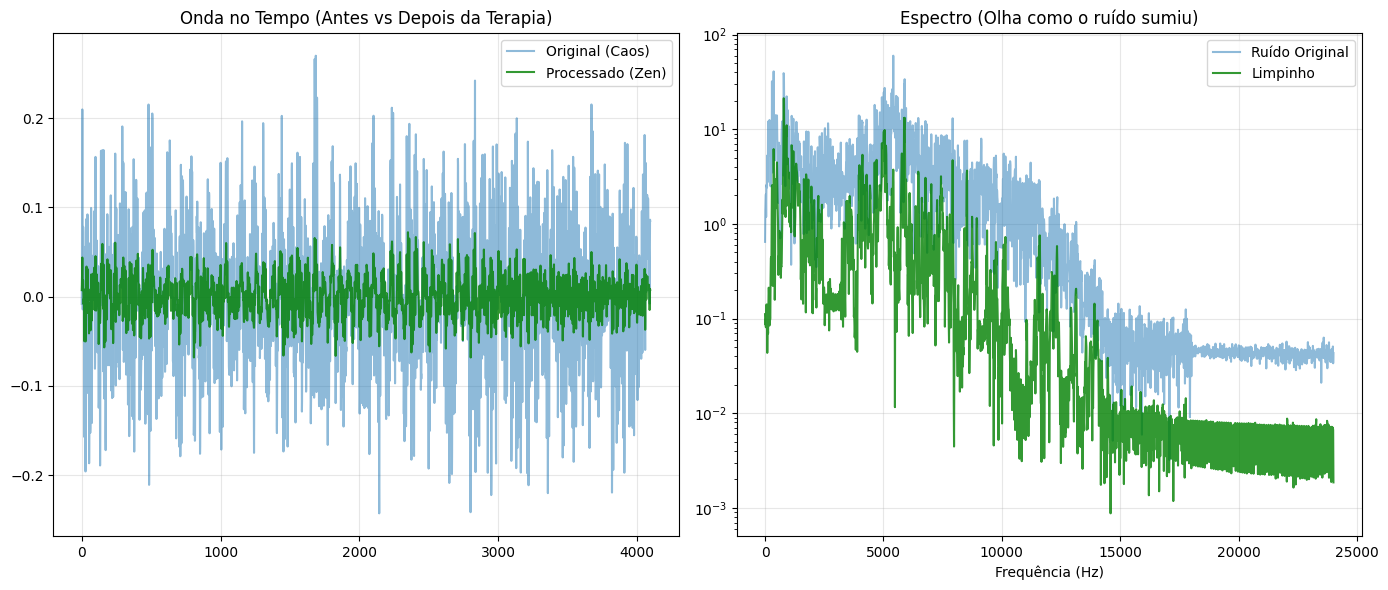


--- Audio Original (A desgraça) ---



--- Amostra do Ruído (O culpado) ---



--- Audio Final (Glória a Deus) ---


In [5]:
plt.figure(figsize=(14, 6))

mid_point = len(data_audio) // 2
sample_slice = slice(mid_point, mid_point + 4096)

fft_orig = np.abs(np.fft.rfft(data_audio[sample_slice]))
fft_clean = np.abs(np.fft.rfft(audio_limpo[sample_slice]))
freqs = np.fft.rfftfreq(4096, 1/sr_audio)


plt.subplot(1, 2, 1)
plt.title("Onda no Tempo (Antes vs Depois da Terapia)")
plt.plot(data_audio[sample_slice], alpha=0.5, label='Original (Caos)')
plt.plot(audio_limpo[sample_slice], alpha=0.8, color='green', label='Processado (Zen)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.title("Espectro (Olha como o ruído sumiu)")
plt.semilogy(freqs, fft_orig, alpha=0.5, label='Ruído Original')
plt.semilogy(freqs, fft_clean, color='green', alpha=0.8, label='Limpinho')
plt.legend()
plt.xlabel("Frequência (Hz)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n--- Audio Original (A desgraça) ---")
display(Audio('audio_com_furadeira.wav'))

print("\n--- Amostra do Ruído (O culpado) ---")
display(Audio('amostra.wav'))

print("\n--- Audio Final (Glória a Deus) ---")
display(Audio('audio_da_paz.wav'))